In [8]:
import numpy as np
import matplotlib.pyplot as plt
from dump_snake import dump_snake_to_povray


In [9]:
def diff(vect, out):
    shape = vect.shape
    N = shape[0]
    for j in range(N+1):
        if j == 0:
            out[j] = vect[j]
        elif (j>0) & (j <= N-1):
            out[j] = vect[j]-vect[j-1]
        else:
            out[j] = -vect[N-1]


def dave(vect, out):
    N = len(vect)
    for j in range(N+1):
        if j == 0:
            out[j] = vect[j]/2
        elif (j>0) & (j <= N-1):
            out[j] = (vect[j]+vect[j-1])/2
        else:
            out[j] = vect[N-1]/2


def skew(axis, output ):
    output[0] = [0,-axis[2],axis[1]]
    output[1] = [axis[2],0,-axis[0]]
    output[2] = [-axis[1],axis[0],0]

U = np.zeros((3,3))
IDENTITY = np.identity(3)
def rodrigues(vector):
    #Vector is quantity dt/2*wi_L
    theta = np.linalg.norm(vector)
    theta %= 2 * np.pi
    #print(theta)
    if np.linalg.norm(vector) != 0:
        axis = vector/np.linalg.norm(vector)
    else:
        axis = vector
    #print(axis)
    skew(axis,U)
    R = IDENTITY + np.sin(theta)*U + (1-np.cos(theta))*U@U    
    return R

def logMatrix(matrix, output):
    # log(R) = R - R.T  Skew symm matrix, must convert back to vector
    cosVal = (np.trace(matrix)-1)/2
    if cosVal >=1 or cosVal <= -1 :
        return np.zeros(3)
    theta = np.arccos((np.trace(matrix)-1)/2)

    if theta == 0:
        return np.zeros(3)
    temp = matrix - matrix.T
    #output = np.zeros(3)
    output[0] = temp[2][1]
    output[1] = temp[0][2]
    output[2] = temp[1][0]
    output /= np.linalg.norm(output)
    output *= theta
    #return output*theta


def l_from_r(l_list, r_list):
    #temp = np.pad(r_list,(1,0), 'constant', constant_values = (0,0))
    #temp2 = np.pad(r_list,(0,1), 'constant', constant_values = (0,0))
    
    for i in range(len(l_list)):
        l_list[i] = r_list[i+1]-r_list[i]
    
    #temp2 = np.vstack((r_list,np.array([0,0,0])))
    #temp3 = temp2-temp
    #return(temp3[1:len(r_list)])
    
def t_from_l(t_array,l_array):
    for i in range(len(l_array)):
        t_array[i]=l_array[i]/np.linalg.norm(l_array[i])
    
def e_from_l(e_array,l_array):
    for i in range(len(l_array)):
        e_array[i]=np.linalg.norm(l_array[i])/chunk_length


In [10]:
""" Calculates the bspline given control points and end points"""

__author__ = "Tejaswin Parthasarathy"
__license__ = "GPL"

#import numpy as np
#import matplotlib.pyplot as plt


def snake_bspline(t_coeff, l_centerline=1.0, keep_pts=False):
    """ Generates a bspline object that plots the spline interpolant for
    any vector x. Optionally takes in a centerline length, set to 1.0 by
    default and keep_pts for keeping record of control points

    Parameters
    ----------
    t_coeff : np.array
        The spline coefficients, denoted by :math:`beta_i`. Note that the first
        and the last values are set to zero by default.
    l_centreline : float
        The length of the centerline in meters.
    keep_pts : boolean, optional
        If True, we keep record of control point and coefficients at those points
        by returned as a (3, ) tuple. If False, returns only the splibe object.
        Defaults to False.

    Returns
    -------
    spline : scipy.interpolate.Bspline class
        A spline class that can be called as spline(x), where x are the points at
        which the spline needs to be evaluated.
    """
    # Divide into n_control_pts numbrer of points (n_ctr_pts-1) regions
    control_pts = l_centerline * np.linspace(0.0, 1.0, t_coeff.shape[0])

    # Degree of b-spline required. Set to cubic
    degree = 3

    # Update coefficients at the head and tail
    # Setting it to 0.0 here
    beta_head = 0.0
    beta_tail = 0.0

    if keep_pts:
        # Keep record of control point and coefficient at those points
        return __bspline_impl__(control_pts, t_coeff, beta_head, beta_tail,
                                degree)
    else:
        return __bspline_impl__(control_pts, t_coeff, beta_head, beta_tail,
                                degree)[0]


def __bspline_impl__(x_pts, t_c, b_head, b_tail, t_k):
    """
        """
    from scipy.interpolate import BSpline

    # Update the coefficients
    #
    t_c = np.hstack((b_head, t_c, b_tail))

    # Update the knots
    # You need 2 additional knots for the head and tail control points
    # You need degree + 1 additional knots to sink into the head and tail for
    # controlling C^k smoothness. We set it to 0.0
    n_upd = x_pts.shape[0] + 2 + (t_k + 1)

    # The first and last points are always fixed
    x_first = x_pts[0]
    x_last = x_pts[-1]
    x_pts = np.hstack((x_first, x_pts, x_last))

    # Generate the knots
    knots_updated = np.zeros(n_upd, )
    # Sink first degree-1 knots into head
    knots_updated[:t_k - 1] = x_first
    # Middle knot locations correspond to x_locations
    knots_updated[t_k - 1:n_upd - (t_k - 1)] = x_pts
    # Sink first degree-1 knots into tail
    knots_updated[n_upd - (t_k - 1):] = x_last

    return BSpline(knots_updated, t_c, t_k, extrapolate=False), x_pts, t_c


def test_bspline():
    """ Test object for the bspline function"""
    l_centre = 1.0
    t_coeff = np.abs(np.random.randn(6, ))
    my_spline, ctr_pts, ctr_coeffs = snake_bspline(t_coeff, keep_pts=True)
    my_spline(2.0)

    from matplotlib import pyplot as plt
    s = np.linspace(0.0, l_centre, 200)
    plt.plot(s, my_spline(s))
    plt.plot(ctr_pts, ctr_coeffs, 'kx')
    plt.show()
    
threshold = .001
def stepFunc(num):
    if num > threshold:
        return 0
    return 1

UkForward = 1.019368
Ukback = 1.5 * UkForward
UsForward = 2*UkForward
UsBack = 1.5* UsForward
thresholdV = 10**(-8)

def getFric(velocity, normalF):
    speed = np.linalg.norm(velocity)
    unit = -1 * velocity / speed
    magFriction = np.linalg.norm(normalF)
    
    mu = 0
    if speed > thresholdV:
        if velocity[0] > 0:
            mu = UkForward
        else:
            mu = Ukback
    else:
        if velocity[0] > 0:
            mu = UsForward
        else:
            mu = UsBack
            
    return unit*mu * magFriction
    

In [11]:
'''Beam Validation'''

rho = 10**3      #density  (kg/m^3)
E = 1*10**7       #Young's modulus (Pa)
G = 2*E/3        #shear modulus (Pa)
#F_mag = 15     #force (N)
L = 1              #rod length (m)
RADIUS = 0.025      #rod radius (m)
MuscPeriod = 1 # muscular activation period
Kw = 1

groundDissipation = 10**(-6)
g = 9.81


T = 5*10**3        #simulation time (s)
n = 50            #number of discrete pts 
gamma = 5       #dissipation const (kg/(m*s))
dt = 10**(-5)    #time step (s)
#e = 1             #stretch factor

chunk_length = L/(n-1)
#chunk_length = L/99

AREA = np.pi * RADIUS**2
MASS = AREA * chunk_length * rho

I1 = np.pi*RADIUS**4/4
I2 = np.pi*RADIUS**4/4
I3 = np.pi*RADIUS**4/2

### Stiffness Matricies, Constant
J = np.diag(np.array([MASS*chunk_length**2/12,MASS*chunk_length**2/12,MASS*RADIUS**2/2]))# M l^2 / 12 , M l^2 / 12,  M*r^2 / 2,
INVJ = np.linalg.inv(J)
S = np.diag(np.array([4*G*AREA/3, 4*G*AREA/3, E*AREA]))
B = np.diag(np.array([E*I1, E*I2, G*I3]))

#initialize rod
r = np.zeros((n,3))             #array of node coordinate vectors
v = np.zeros((n,3))             #array of node velocity vectors
for i in range(len(v)):
    v[i] = np.array([-10**(-9),0,0])

dv = np.zeros((n,3))
Q = np.zeros((n-1,3,3))         #array of Q matrices for each element
w = np.zeros((n-1,3))           #array of angular velocity vectors for each element
dw = np.zeros((n-1,3))
F = np.zeros((n,3))             #array of Force vectors

#F[0] = np.array([-F_mag,0,0])
#F[n-1] = np.array([0,0,-F_mag]) 
C = np.zeros((n-1,3))
sigma = np.zeros((n-1,3))         #shear vector

nodalMass = np.zeros(n)
for i in range(len(nodalMass)):
    if i == 0 or i== len(nodalMass)-1 :
        nodalMass[i] = MASS/2
    else:
        nodalMass[i] = MASS

t_coeff = np.array([0,17.4,48.5,5.4,14.7,0])
lam = 0.97
my_spline = snake_bspline(t_coeff)

for i in range(n):
    r[i] = np.array([i*chunk_length,0,0])
#r[0] = [np.sqrt(3)/2*chunk_length]

matrix = np.zeros((3,3))
matrix[2] = np.array([1,0,0])
matrix[0] = np.array([0,0,1])
matrix[1] = np.cross(matrix[2],matrix[0])

for i in range(n-1):
    Q[i] = np.copy(matrix)  
l = np.zeros((n-1,3))  #list containing tangent vectors

t = np.zeros((n-1,3))
e = np.zeros(n-1)
l_from_r(l,r)
t_from_l(t,l) 
e_from_l(e,l)

for i in range(len(sigma)):
    sigma[i] = Q[i]@(e[i]*t[i]-Q[i][2])
    
K = np.zeros((n-2,3))
beta = np.zeros((n-2,3,3))

for i in range(n-2):
    logMatrix(Q[i+1]@Q[i].T,K[i])
    K[i] /= chunk_length
    beta[i] = B

end_node = []

posit = []
positY = []
positZ = []

Uperp = np.array([0,0,1])

## initializing arrays for diff and dave methods
QUANTITY = np.zeros((n-1,3))

diffBkap = np.zeros((n-1,3))
daveBkross = np.zeros((n-1,3))

bkap = np.zeros((n-2,3))
bkross = np.zeros((n-2,3))
QtcrossSsig = np.zeros((n-1,3))

#fixedMidpt = np.copy(r[n//2])

#Time March
steps = 1000000
for step in range(steps):
    #First Half Position Update
    #print('Step: ')
    #print(step)
    
    r = r + (dt/2)*v   #r half update
    #r[0] = np.array([0,0,0])
    #r[n//2] = fixedMidpt
    
    
    for i in range(len(Q)):
        Q[i] = rodrigues(dt/2*w[i])@Q[i]
    
    #Q[0] = np.copy(matrix)

    
    l_from_r(l, r)    #l half update
    t_from_l(t,l)    #t half update  
    e_from_l(e,l)    #e half update


    for i in range(len(sigma)):   #sigma half update
        sigma[i] = Q[i]@(e[i]*t[i]-Q[i][2])
    for i in range(n-2):
        logMatrix(Q[i+1]@Q[i].T, K[i])
        K[i] /= chunk_length
    
    #Local Accelerations
    
    for i in range(n-1):
        QUANTITY[i] = Q[i].T@S@sigma[i]
    
    diff(QUANTITY,dv)
    dv += F
    for i in range(len(dv)):
        dv[i] /= nodalMass[i]
    v = v + dt*dv
    
    
    for i in range(n-2):
        bkap[i] = beta[i]@K[i]
        bkross[i] = np.cross(K[i],bkap[i])*chunk_length
    
    for i in range(n-1):
        QtcrossSsig[i] = np.cross(Q[i]@t[i],S@sigma[i])
    
    diff(bkap, diffBkap) 
    dave(bkross, daveBkross) 
    
    
    for i in range(len(C)):
        A_node = my_spline(i*chunk_length)*np.sin(2*np.pi*(step*dt)+2*np.pi*(i*chunk_length)/lam)
        A_next_node = my_spline((i+1)*chunk_length)*np.sin(2*np.pi*(step*dt)+2*np.pi*((i+1)*chunk_length)/lam)
        Am = A_next_node - A_node
        C[i] = Q[i]@(Am*Q[i][0])
    
    dw = diffBkap + daveBkross - QtcrossSsig*chunk_length + C
    for i in range(n-1):
        dw[i] = INVJ @ dw[i]
    w = w + dt*dw
    
    #Second Half Position Update
    r = r + dt/2*v
    #r[0] = np.array([0,0,0])
    #r[n//2] = fixedMidpt
    
    for i in range(len(Q)):
        Q[i] = rodrigues(dt/2*w[i])@Q[i]
    #Q[0] = matrix
    for i in range(len(F)):
        #F[i] -= dv[i]*dt*gamma
        
        F[i] = stepFunc(r[i][2])*(np.array([0,0,nodalMass[i]])*g + Kw*(threshold - r[i][2]) - groundDissipation* np.dot(v[i], Uperp))* Uperp
        F[i] += getFric(v[i], F[i])
        F[i] += np.array([0,0,-nodalMass[i]*g])
        
        F[i] -= dv[i] * dt * gamma
        

    posit.append(r[n-1][0])
    positY.append(r[n-1][1])
    positZ.append(r[n-1][2])
    
    if step%1000 == 0:
        frame = step//1000
        dump_snake_to_povray(frame,r,RADIUS, "./data/")
        
    



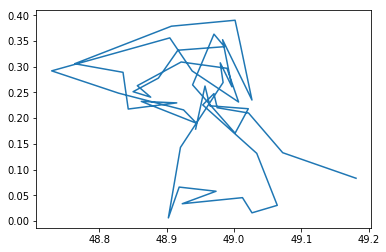

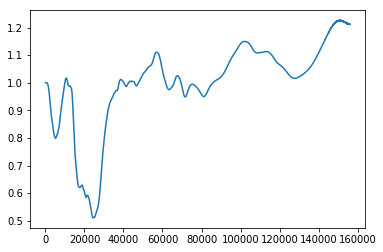

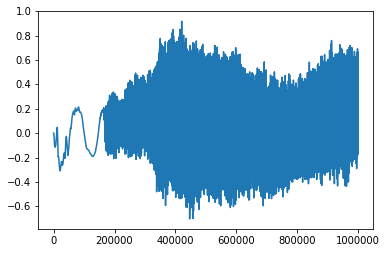

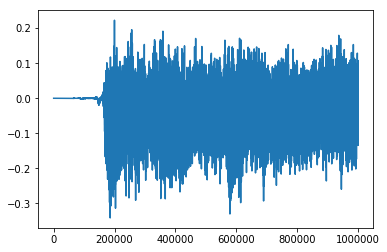

In [13]:
x = []
z = []
for pos in r:
    x.append(pos[0])
    z.append(pos[1])
plt.figure()    
plt.plot(x,z)
plt.figure()
plt.plot(posit[:156000])
plt.figure()
plt.plot(positY)
plt.figure()
plt.plot(positZ)

